In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Using TensorFlow backend.


In [2]:
NUM_WORDS = 20000

class ISEARDataset(object):
    FILENAME = "data/isear_databank.csv"
    EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
    EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
    RANDOM_STATE = 41
  
    def get_classes(self):
        return self.EMOTION_CLASSES
  
    def get_classes_dict(self):
        return self.EMOTION_CLASSES_DICT

    def _sequence_texts(self, texts):
        tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
        tokenizer.fit_on_texts(texts)
        sequences = pad_sequences(tokenizer.texts_to_sequences(texts))
        word_index = tokenizer.word_index
        return sequences, word_index

    def __init__(self, n_items=0):
        data = pd.read_csv(self.FILENAME)

        if n_items > 0:
            data = data.iloc[0:n_items,:]

        data["text"] = data["SIT"]
        data["emotion"] = data["Field1"]

        for emotion in self.get_classes():
            data.loc[data["emotion"] == emotion, "emotion_int"] = self.get_classes_dict()[emotion]

        sequences, word_index = self._sequence_texts(data["text"])
        self.X = sequences
        self.y = data["emotion_int"].values
        self.word_index = word_index

In [3]:
dataset = ISEARDataset()
# dataset = ISEARDataset(200)
X_train, X_test, y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=0.3, random_state=dataset.RANDOM_STATE, stratify=dataset.y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=dataset.RANDOM_STATE, stratify=y_train)

In [4]:
print("X_train.shape: (%d, %d)" % X_train.shape)
print("y_train.shape: (%d)" % y_train.shape)

print("X_valid.shape: (%d, %d)" % X_valid.shape)
print("y_valid.shape: (%d)" % y_valid.shape)

print("X_test.shape: (%d, %d)" % X_test.shape)
print("y_test.shape: (%d)" % y_test.shape)

X_train.shape: (4292, 192)
y_train.shape: (4292)
X_valid.shape: (1074, 192)
y_valid.shape: (1074)
X_test.shape: (2300, 192)
y_test.shape: (2300)


In [5]:
np.save("pytorch_isear_X_train.npy", X_train)
np.save("pytorch_isear_X_valid.npy", X_valid)
np.save("pytorch_isear_X_test.npy", X_test)

np.save("pytorch_isear_y_train.npy", y_train)
np.save("pytorch_isear_y_valid.npy", y_valid)
np.save("pytorch_isear_y_test.npy", y_test)

In [6]:
X_train = np.load("pytorch_isear_X_train.npy")
X_valid = np.load("pytorch_isear_X_valid.npy")
X_test = np.load("pytorch_isear_X_test.npy")

y_train = np.load("pytorch_isear_y_train.npy")
y_valid = np.load("pytorch_isear_y_valid.npy")
y_test = np.load("pytorch_isear_y_test.npy")

In [7]:
dic = dataset.get_classes_dict()
labels = dataset.get_classes()
n_classes = len(labels)
print("class dictionary: %s" % dic)
print("class labels: %s" % labels)
print("number of bins: %s" % n_classes)

class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
number of bins: 7


bins: [0, 1, 2, 3, 4, 5, 6, 7]


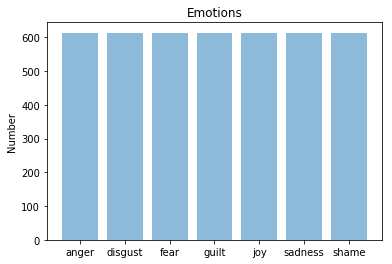

In [8]:
bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [9]:
from torch import autograd

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = autograd.Variable(target)
        
    return target
  
y = torch.LongTensor(y_train).view(-1, 1, 1, 1)
print("y.shape:", y.shape)
y_onehot = make_one_hot(y, C=7)
print("y_onehot.shape:", y_onehot.shape)

y.shape: torch.Size([4292, 1, 1, 1])
y_onehot.shape: torch.Size([4292, 7, 1, 1])


In [10]:
import torch
from torch.utils import data

class ISEAR_Tensor_Dataset(data.TensorDataset):
  
  def __init__(self, text, emotion, num_class=2):
    X = torch.LongTensor(text)
    y = torch.LongTensor(emotion).view(-1, 1, 1, 1)
    y_onehot = make_one_hot(y, num_class)
    y_onehot = y_onehot.view(y_onehot.shape[0], y_onehot.shape[1])
    tensors = []
    tensors.append(X)
    tensors.append(y_onehot)
    super().__init__(*tensors)

In [11]:
train_dataset = ISEAR_Tensor_Dataset(X_train, y_train, num_class=7)
valid_dataset = ISEAR_Tensor_Dataset(X_valid, y_valid, num_class=7)
test_dataset = ISEAR_Tensor_Dataset(X_test, y_test, num_class=7)

In [12]:
print("train_dataset.tensors[0].shape:", train_dataset.tensors[0].shape)
print("train_dataset.tensors[1].shape:", train_dataset.tensors[1].shape)

train_dataset.tensors[0].shape: torch.Size([4292, 192])
train_dataset.tensors[1].shape: torch.Size([4292, 7])


In [13]:
print("train_dataset length:", len(train_dataset))
print("valid_dataset length:", len(valid_dataset))
print("test_dataset length:", len(test_dataset))

train_dataset length: 4292
valid_dataset length: 1074
test_dataset length: 2300


In [14]:
batch_size = 50

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Word2Vec Embedding

In [15]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('../../Datasets/WordEmbeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300

vocabulary_size = min(len(dataset.word_index)+1, NUM_WORDS)
embedding_weights = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in dataset.word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_weights[i] = embedding_vector
    except KeyError:
        embedding_weights[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

In [16]:
file_embedding_weights = "pytorch_isear_embedded_matrix_word2vec_googlenews.npy"
np.save(file_embedding_weights, embedding_weights)

## Reload embedding layer

In [17]:
file_embedding_weights = "pytorch_isear_embedded_matrix_word2vec_googlenews.npy"
embedding_weights = np.load(file_embedding_weights)
print("embedding_weights.shape:", embedding_weights.shape)

embedding_weights.shape: (9014, 300)


In [18]:
embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim=EMBEDDING_DIM, _weight=torch.Tensor(embedding_weights))

In [19]:
for param in embedding.parameters():
    print("embedding.requires_grad:", param.requires_grad)

embedding.requires_grad: True


## Define the classifier

In [20]:
class ConvNetClassifier(nn.Module):
    
    def __init__(self, embedding, input_dim, embedding_dim=300, 
                 output_dim=7, filter_dim=100, filter_sizes=[3,4,5], drop_rate=0.5):
        super(ConvNetClassifier, self).__init__()
        
        self.embedding = embedding
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.filter_sizes = filter_sizes
        self.filter_dim = filter_dim
        self.output_dim = output_dim
        self.drop_rate = drop_rate
        
        self.conv2d_1 = nn.Conv2d(
            in_channels=1, out_channels=self.filter_dim, 
            kernel_size=(self.filter_sizes[0], self.embedding_dim))
        
        self.conv2d_2 = nn.Conv2d(
            in_channels=1, out_channels=self.filter_dim, 
            kernel_size=(self.filter_sizes[1], self.embedding_dim))
        
        self.conv2d_3 = nn.Conv2d(
            in_channels=1, out_channels=self.filter_dim, 
            kernel_size=(self.filter_sizes[2], self.embedding_dim))
        
        self.maxpool2d_1 = nn.MaxPool2d(
            kernel_size=(self.input_dim-self.filter_sizes[0]+1, 1), 
            stride=1)
        
        self.maxpool2d_2 = nn.MaxPool2d(
            kernel_size=(self.input_dim-self.filter_sizes[1]+1, 1), 
            stride=1)
        
        self.maxpool2d_3 = nn.MaxPool2d(
            kernel_size=(self.input_dim-self.filter_sizes[2]+1, 1), 
            stride=1)
        
        self.linear = nn.Linear(in_features=self.embedding_dim, out_features=self.output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        reshaped = embedded.view(embedded.shape[0], 1, embedded.shape[1], self.embedding_dim)
        
        conv2d_1 = F.relu(self.conv2d_1(reshaped))
        conv2d_2 = F.relu(self.conv2d_2(reshaped))
        conv2d_3 = F.relu(self.conv2d_3(reshaped))
        
        maxpool2d_1 = self.maxpool2d_1(conv2d_1)
        maxpool2d_2 = self.maxpool2d_2(conv2d_2)
        maxpool2d_3 = self.maxpool2d_3(conv2d_3)
        
        concat = torch.cat([maxpool2d_1, maxpool2d_2, maxpool2d_3], dim=1)
        flatten = concat.view(concat.shape[0], concat.shape[1])
        dropout = F.dropout(flatten, self.drop_rate)
        output = F.softmax(self.linear(dropout))
        
        return output

In [21]:
input_dim = X_train.shape[1]
filter_dim = 100
embedding_dim = 300
filter_sizes = [3,4,5]
drop_rate = 0.5
output_dim = 7
model = ConvNetClassifier(embedding, input_dim, embedding_dim, output_dim, filter_dim, filter_sizes, drop_rate)
model = model.to(device)

In [22]:
train_loader.__dict__

{'dataset': <__main__.ISEAR_Tensor_Dataset at 0x7feaf942a1d0>,
 'batch_size': 50,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7feaf942a208>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7feaf942a128>,
 '_DataLoader__initialized': True}

In [23]:
def train(epoch, model, data_loader, device, optimiser, loss_fn=nn.BCELoss(), log_interval=100):
    #####################
    # Train model
    #####################

    # switch model to training mode, clear gradient accumulators
    model.train()
    # model.hidden = model.init_hidden()
    
    train_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.data # sum up batch loss
        
        pred = output.max(1, keepdim=True)[1]
        pred = pred.view(pred.size(0))

        target = target.max(1, keepdim=True)[1]
        target = target.view(target.size(0))

        correct = pred.eq(target.view_as(pred)).sum()
        total_correct += correct

        all_pred += pred.cpu().numpy().tolist()
        all_target += target.cpu().numpy().tolist()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}\t/\t{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
    
    print('Train: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return train_loss, all_pred, all_target

In [24]:
def evaluate(model, data_loader, device, loss_fn=nn.BCELoss()):
    #####################
    # Evaluation model
    #####################
    model.eval()
    eval_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            eval_loss += loss_fn(output, target).data # sum up batch loss
            
            pred = output.max(1, keepdim=True)[1]
            pred = pred.view(pred.size(0))
            
            target = target.max(1, keepdim=True)[1]
            target = target.view(target.size(0))
            
            correct = pred.eq(target.view_as(pred)).sum()
            total_correct += correct

            all_pred += pred.cpu().numpy().tolist()
            all_target += target.cpu().numpy().tolist()

    print('Evaluate: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        eval_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return eval_loss, all_pred, all_target

In [25]:
loss_fn = nn.BCELoss()
log_interval = 10
max_epochs = 10
learning_rate = 1e-3
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_hist = np.zeros(max_epochs)
eval_loss_hist = np.zeros(max_epochs)

for epoch in range(max_epochs):
  
    train_loss, train_pred, train_target = train(epoch, model, train_loader, device, optimiser, loss_fn, log_interval)
    train_loss_hist[epoch] = train_loss
    
    valid_loss, valid_pred, valid_target = evaluate(model, valid_loader, device, loss_fn=nn.BCELoss())
    eval_loss_hist[epoch] = valid_loss

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0	/	4292	(0%)]	Loss: 0.414288
Train Epoch: 0 [500	/	4292	(12%)]	Loss: 0.417870
Train Epoch: 0 [1000	/	4292	(23%)]	Loss: 0.417129
Train Epoch: 0 [1500	/	4292	(35%)]	Loss: 0.410955
Train Epoch: 0 [2000	/	4292	(47%)]	Loss: 0.403578
Train Epoch: 0 [2500	/	4292	(58%)]	Loss: 0.398571
Train Epoch: 0 [3000	/	4292	(70%)]	Loss: 0.389930
Train Epoch: 0 [3500	/	4292	(81%)]	Loss: 0.390744
Train Epoch: 0 [4000	/	4292	(93%)]	Loss: 0.406144
Train: Average loss: 34.9582, Accuracy: 907/4292 (21%)
Evaluate: Average loss: 8.6671, Accuracy: 296/1074 (27%)

Train Epoch: 1 [0	/	4292	(0%)]	Loss: 0.373956
Train Epoch: 1 [500	/	4292	(12%)]	Loss: 0.367984
Train Epoch: 1 [1000	/	4292	(23%)]	Loss: 0.366475
Train Epoch: 1 [1500	/	4292	(35%)]	Loss: 0.362407
Train Epoch: 1 [2000	/	4292	(47%)]	Loss: 0.326050
Train Epoch: 1 [2500	/	4292	(58%)]	Loss: 0.344212
Train Epoch: 1 [3000	/	4292	(70%)]	Loss: 0.323629
Train Epoch: 1 [3500	/	4292	(81%)]	Loss: 0.332665
Train Epoch: 1 [4000	/	4292	(93%)]	Loss: 0.2716

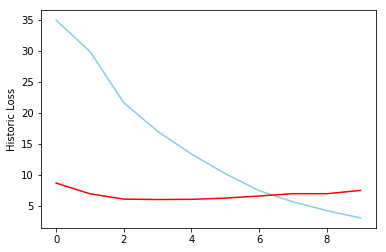

In [26]:
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, color='skyblue')
plt.plot(eval_loss_hist, color='red')
plt.ylabel('Historic Loss')
plt.show()

In [27]:
model_path = 'pytorch_isear_convnet_word2vec_googlenews_model.h5'
weight_path = 'pytorch_isear_convnet_word2vec_googlenews_weights.h5'

torch.save(model.state_dict(), weight_path)
torch.save(model, model_path)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConvNetClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
test_loss, test_pred, test_target = evaluate(model, test_loader, device, loss_fn)

/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate: Average loss: 15.1099, Accuracy: 1344/2300 (58%)



In [29]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

cf_matrix = confusion_matrix(test_target, test_pred)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,175,39,17,42,14,19,23
disgust,38,202,21,15,13,16,24
fear,13,18,223,21,14,23,16
guilt,43,29,19,169,10,19,39
joy,22,15,12,12,233,23,11
sadness,40,20,20,18,23,195,13
shame,37,34,17,57,26,11,147


In [30]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Figure(288x216)


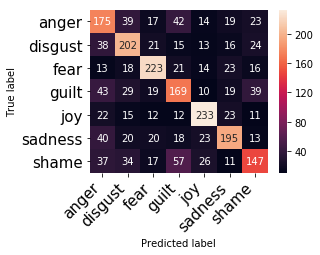

In [31]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [32]:
test_accuracy = accuracy_score(test_target, test_pred)
print("test accuracy:", test_accuracy)

test accuracy: 0.5843478260869566


### Performance score for each classes

In [33]:
precision, recall, fscore, support = precision_recall_fscore_support(test_target, test_pred)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
anger,0.4755,0.5319,0.5022,329
disgust,0.5658,0.6140,0.5889,329
fear,0.6778,0.6799,0.6788,328
guilt,0.5060,0.5152,0.5106,328
joy,0.6997,0.7104,0.7050,328
sadness,0.6373,0.5927,0.6142,329
shame,0.5385,0.4468,0.4884,329


### Cohen Kappa Score

In [34]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(test_target, test_pred)
print("kappa:", kappa_score)

kappa: 0.5150735637902775
